# Setup

In [2]:
import os
import sys
import random
from collections import Counter

import numpy as np
import pyloudnorm as pln
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display
import librosa.display

In [3]:
# We're going to use utilities from the core framework
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.config import config_from_args
from src.utils.build import build_device, build_datasets

In [4]:
def build_dataset(name):
    data_path = os.path.abspath(os.path.join("../../processed_data/", name))
    config_path = os.path.abspath(os.path.join("../../../configs/audio_config.json"))
    config = config_from_args([
        f"--data={data_path}",
        f"--config={config_path}",
        f"--dataset=both_mic_classif",
        f"--stratify=0"
    ])
    device = build_device()
    dataset, *_ = build_datasets(config, device)
    return dataset

In [5]:
dataset = build_dataset("quiet_front-ear")
error_dataset = build_dataset("quiet_front-ear_errors")
demo_dataset = build_dataset("quiet_front-ear_demo_no_noise")

In [6]:
print(f"Normal dataset: {len(dataset)} samples")
print(f"Error dataset: {len(error_dataset)} samples")
print(f"Demo dataset: {len(demo_dataset)} samples")

Normal dataset: 2499 samples
Error dataset: 5 samples
Demo dataset: 30 samples


# Load

In [7]:
def get_raw(dataset):
    raw_data = [dataset.loader.load(i) for i in range(len(dataset))]

    # load() returns (input, target, is_train)
    raw_inputs, raw_targets, _ = list(zip(*raw_data))

    # Each input element is a list of tuples, where each tuple is (channel sample rate, channel data)
    # Channels are in ther order [reg mic 1, reg mic 2, throat mic 1, throat mic 2]
    raw_reg_1, raw_reg_2, raw_throat_1, raw_throat_2 = list(zip(*raw_inputs))

    # Get sample rates
    reg_sr = raw_reg_1[0][0]
    throat_sr = raw_throat_1[0][0]

    # Get just raw data, stripping out sample rate
    _, raw_reg_1 = list(zip(*raw_reg_1))
    _, raw_reg_2 = list(zip(*raw_reg_2))
    _, raw_throat_1 = list(zip(*raw_throat_1))
    _, raw_throat_2 = list(zip(*raw_throat_2))

    return reg_sr, throat_sr, raw_reg_1, raw_reg_2, raw_throat_1, raw_throat_2, raw_targets

In [8]:
def get_proc(dataset):
    # Each element is a dictionary with keys 'input' and 'target'
    # Input is a spectogram, target is an encoded label
    processed_data = [d for d in dataset]
    processed_inputs = [d["input"].numpy() for d in processed_data]
    processed_targets = [d["target"] for d in processed_data]

    # Channels are in ther order [reg mic 1, reg mic 2, throat mic 1, throat mic 2]
    proc_reg_1 = [spec[0, :, :] for spec in processed_inputs]
    proc_reg_2 = [spec[1, :, :] for spec in processed_inputs]
    proc_throat_1 = [spec[2, :, :] for spec in processed_inputs]
    proc_throat_2 = [spec[3, :, :] for spec in processed_inputs]
    
    return proc_reg_1, proc_reg_2, proc_throat_1, proc_throat_2

In [9]:
def build_splits(dataset):
    reg_sr, throat_sr, raw_reg_1, raw_reg_2, raw_throat_1, raw_throat_2, raw_targets = get_raw(dataset)
    proc_reg_1, proc_reg_2, proc_throat_1, proc_throat_2 = get_proc(dataset)
    
    # Make by-label splits
    labels = list(set(list(raw_targets) + ["up", "down", "select", "back", "repeat"]))

    label_splits = {l: {
        "raw_reg_1": [],
        "raw_reg_2": [],
        "raw_throat_1": [],
        "raw_throat_2": [],
        "proc_reg_1": [],
        "proc_reg_2": [],
        "proc_throat_1": [],
        "proc_throat_2": [],
    } for l in labels}

    for i, label in enumerate(raw_targets):
        label_splits[label]["raw_reg_1"].append(raw_reg_1[i])
        label_splits[label]["raw_reg_2"].append(raw_reg_2[i])
        label_splits[label]["raw_throat_1"].append(raw_throat_1[i])
        label_splits[label]["raw_throat_2"].append(raw_throat_2[i])
        label_splits[label]["proc_reg_1"].append(proc_reg_1[i])
        label_splits[label]["proc_reg_2"].append(proc_reg_2[i])
        label_splits[label]["proc_throat_1"].append(proc_throat_1[i])
        label_splits[label]["proc_throat_2"].append(proc_throat_2[i])
    
    label_splits["all"] = {}
    label_splits["all"]["raw_reg_1"] = raw_reg_1
    label_splits["all"]["raw_reg_2"] = raw_reg_2
    label_splits["all"]["raw_throat_1"] = raw_throat_1
    label_splits["all"]["raw_throat_2"] = raw_throat_2
    label_splits["all"]["proc_reg_1"] = proc_reg_1
    label_splits["all"]["proc_reg_2"] = proc_reg_2
    label_splits["all"]["proc_throat_1"] = proc_throat_1
    label_splits["all"]["proc_throat_2"] = proc_throat_2
    label_splits["all"]["raw_targets"] = raw_targets

    return label_splits, reg_sr, throat_sr

In [10]:
splits, reg_sr, throat_sr = build_splits(dataset)
error_splits, error_reg_sr, error_throat_sr = build_splits(error_dataset)
demo_splits, demo_reg_sr, demo_throat_sr = build_splits(demo_dataset)

In [11]:
assert (reg_sr == error_reg_sr and reg_sr == demo_reg_sr)
assert (throat_sr == error_throat_sr and throat_sr == demo_throat_sr)

In [12]:
all_splits = {
    "Train": splits,
    "Error": error_splits,
    "Demo": demo_splits
}

# Initial Exploration

In [13]:
plt.rcParams['figure.dpi'] = 100  # Make plots appear larger

## Dataset Size

In [14]:
for name, split in all_splits.items():
    counts = Counter(split["all"]["raw_targets"])
    counts["total"] = len(split["all"]["raw_targets"])
    
    print(f"{name}:")
    for key, value in counts.items():
        print(f"  {key}: {value} samples")

    count_labels = ["Up", "Down", "Select", "Back", "Repeat"]
    counts = [counts[l.lower()] for l in count_labels]

Train:
  down: 499 samples
  select: 500 samples
  repeat: 500 samples
  back: 500 samples
  up: 500 samples
  total: 2499 samples
Error:
  up: 3 samples
  repeat: 1 samples
  back: 1 samples
  total: 5 samples
Demo:
  select: 6 samples
  up: 6 samples
  back: 6 samples
  repeat: 6 samples
  down: 6 samples
  total: 30 samples


## Sample Lengths

In [15]:
def _to_lens(data, sr=throat_sr):
    data = [len(d) / sr * 1000 for d in data]
    if not data:
        return [0]
    return data

def plot_lens(split, axs):
    # Assuming all raw input channels have same length
    lens = [
        _to_lens(split["all"]["raw_throat_1"]),
        _to_lens(split["up"]["raw_throat_1"]),
        _to_lens(split["down"]["raw_throat_1"]),
        _to_lens(split["select"]["raw_throat_1"]),
        _to_lens(split["back"]["raw_throat_1"]),
        _to_lens(split["repeat"]["raw_throat_1"]),
    ]
    len_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]
    
    axs[0].boxplot(lens, labels=len_labels)
    axs[0].set_ylim(0, 3000)

    axs[1].violinplot(
        lens,
        showextrema=True,
        showmedians=True
    )
    axs[1].set_xticks(list(range(1, len(len_labels) + 1)))
    axs[1].set_xticklabels(len_labels)
    axs[1].set_ylim(0, 3000)


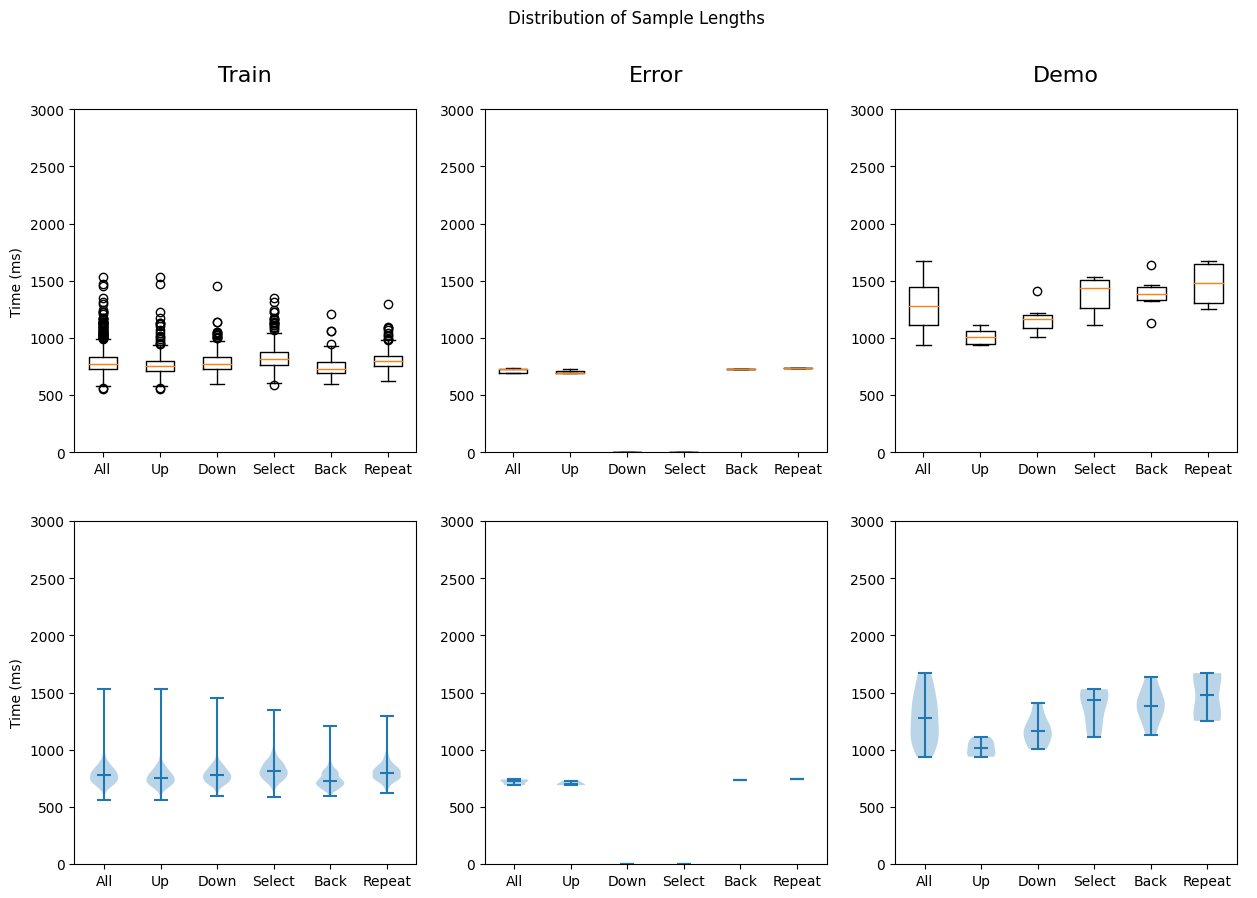

In [16]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(15, 10), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    box_ax = fig.add_subplot(2, len(all_splits), i + 1)
    violin_ax = fig.add_subplot(2, len(all_splits), i + 1 + len(all_splits))
    if (i == 0):
        box_ax.set_ylabel("Time (ms)")
        violin_ax.set_ylabel("Time (ms)")
    plot_lens(split, (box_ax, violin_ax))

plt.suptitle("Distribution of Sample Lengths", y=0.98)
plt.show()

## Loudness

In [17]:
def _to_loudness(data, sr=throat_sr):
    meter = pln.Meter(sr)
    data = [d.astype(np.float32) for d in data]
    data = [meter.integrated_loudness(d) for d in data]
    return data if data else [0]

def plot_loudness(split, axs, channel="raw_throat_1"):
    loudnesses = [
        _to_loudness(split["all"][channel]),
        _to_loudness(split["up"][channel]),
        _to_loudness(split["down"][channel]),
        _to_loudness(split["select"][channel]),
        _to_loudness(split["back"][channel]),
        _to_loudness(split["repeat"][channel]),
    ]
    loudness_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]

    axs[0].boxplot(loudnesses, labels=loudness_labels)
    axs[0].set_ylim(0, 80)
    axs[0].set_ylabel("Loudness (dB LUFS)")

    axs[1].violinplot(
        loudnesses,
        showextrema=True,
        showmedians=True
    )
    axs[1].set_xticks(list(range(1, len(loudness_labels) + 1)))
    axs[1].set_xticklabels(loudness_labels)
    axs[1].set_ylim(0, 80)
    axs[1].set_ylabel("Loudness (dB LUFS)")

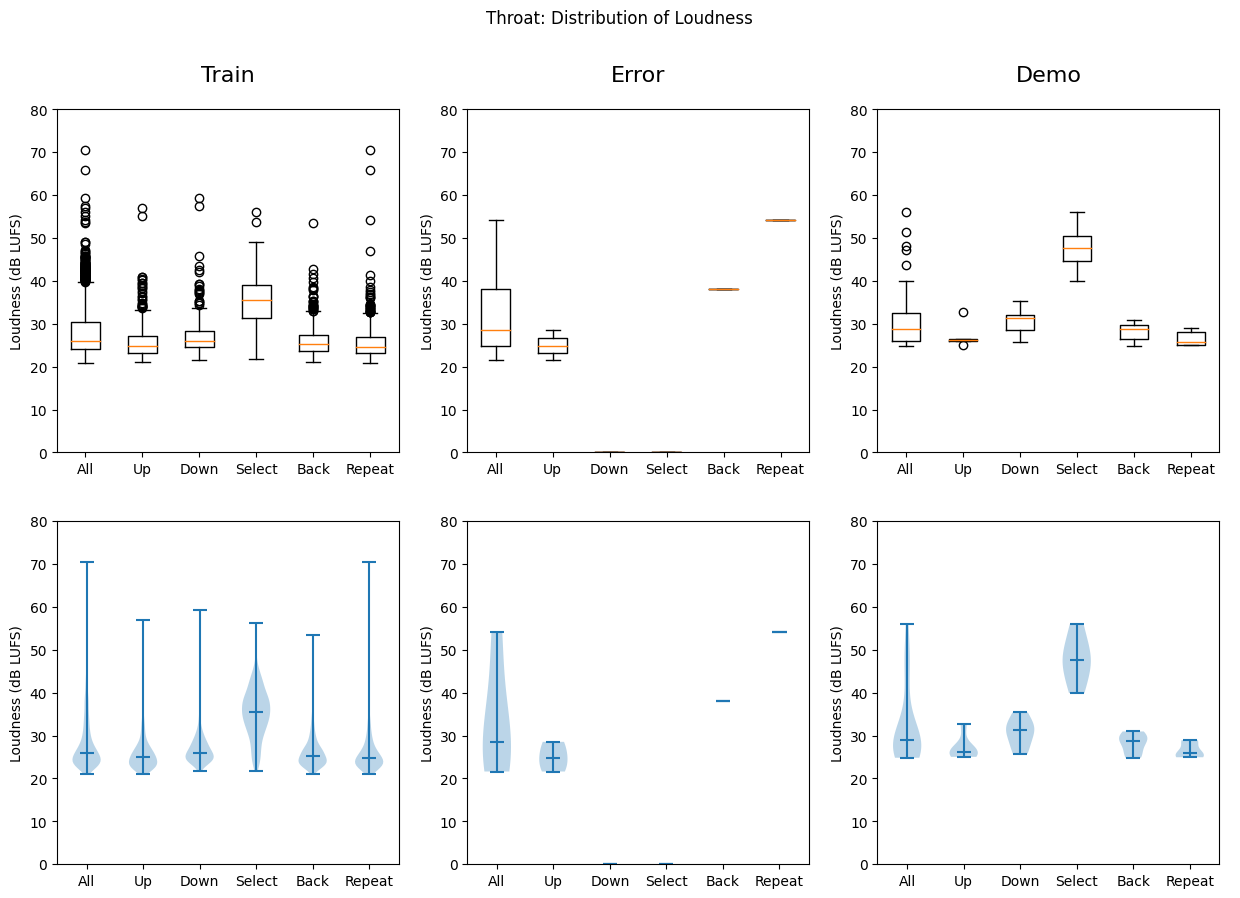

In [18]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(15, 10), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    box_ax = fig.add_subplot(2, len(all_splits), i + 1)
    violin_ax = fig.add_subplot(2, len(all_splits), i + 1 + len(all_splits))
    if (i == 0):
        box_ax.set_ylabel("Time (ms)")
        violin_ax.set_ylabel("Time (ms)")
    plot_loudness(split, (box_ax, violin_ax))

plt.suptitle("Throat: Distribution of Loudness", y=0.98)
plt.show()

/home/l05/code/olin/step/deep-signal-processing/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/l05/code/olin/step/deep-signal-processing/venv/lib/python3.8/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start


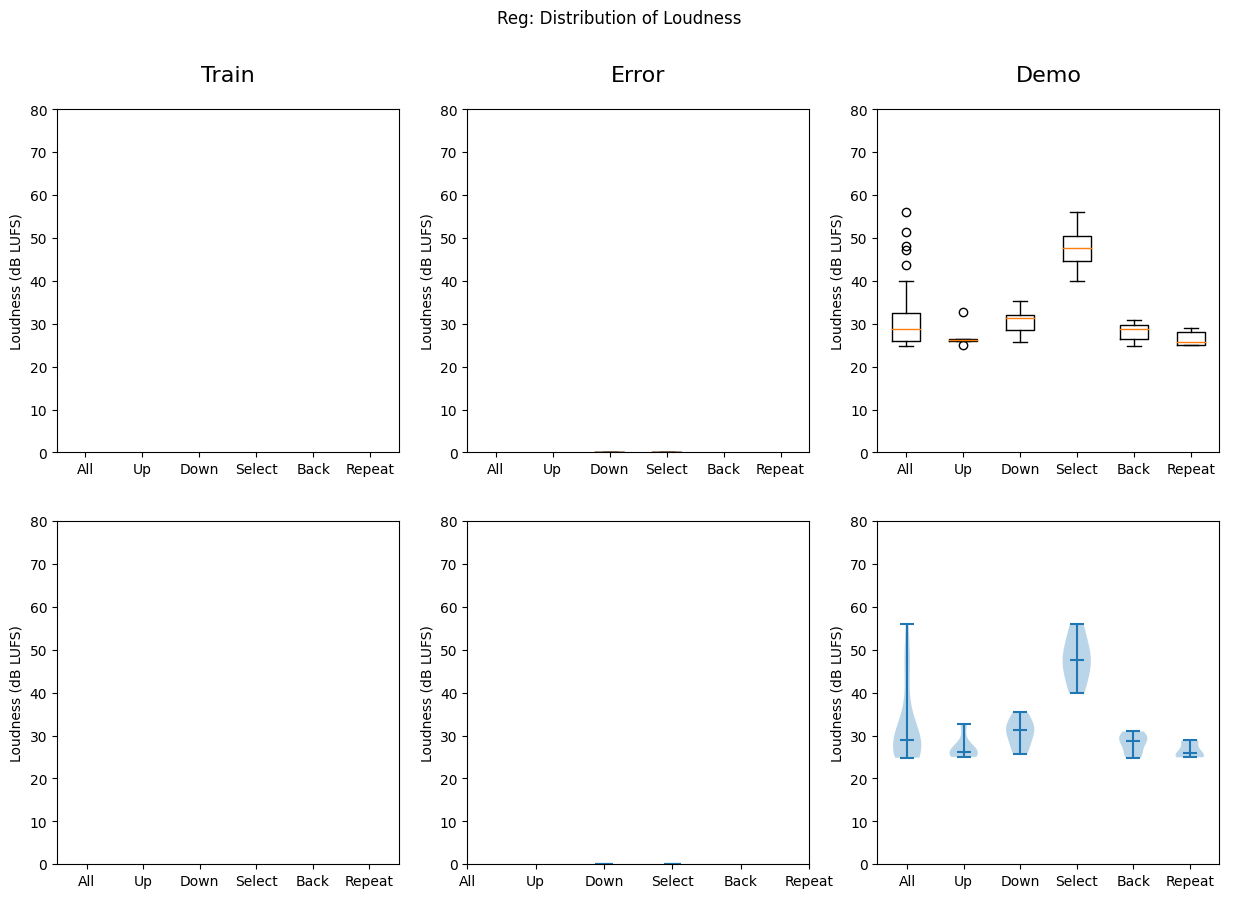

In [25]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(15, 10), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    box_ax = fig.add_subplot(2, len(all_splits), i + 1)
    violin_ax = fig.add_subplot(2, len(all_splits), i + 1 + len(all_splits))
    if (i == 0):
        box_ax.set_ylabel("Time (ms)")
        violin_ax.set_ylabel("Time (ms)")
    plot_loudness(split, (box_ax, violin_ax), channel="raw_reg_1")

plt.suptitle("Reg: Distribution of Loudness", y=0.98)
plt.show()

# Visualizing Samples

In [20]:
num_samples = 12
label = "up"
for split in all_splits.values():
    _num_samples = min(num_samples, len(split[label]["raw_throat_1"]))
    sample_idxs = random.sample(list(range(len(split[label]["raw_throat_1"]))), _num_samples)
    sample_idxs.extend([0 for _ in range(num_samples - _num_samples)])
    split["sample_idxs"] = sample_idxs
    if label == "all":
        split["sample_targets"] = split["all"]["raw_targets"]
    else:
        split["sample_targets"] = [label for _ in range(len(split[label]["raw_throat_1"]))]

In [21]:
def plot_wave(sr, raw, ax, title=None):
    img = librosa.display.waveplot(raw.astype(np.float32), sr=sr, ax=ax)    
    ax.set_ylim(-800, 800)
    ax.set_xlim(0, 2)
    if title:
        ax.set_title(title, fontsize=12)
    return img
    # display(ipd.Audio(raw, rate=sr))
    
def plot_spec(sr, spec, ax, title=None):
    spec_nan = np.isnan(np.sum(spec))
    if spec_nan:
        return None;
    img = librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='mel', hop_length=512, ax=ax)
    if title:
        ax.set_title(title, fontsize=12)
    img.set_clim(10, 120)
    return img
    # display(ipd.Audio(raw, rate=sr))

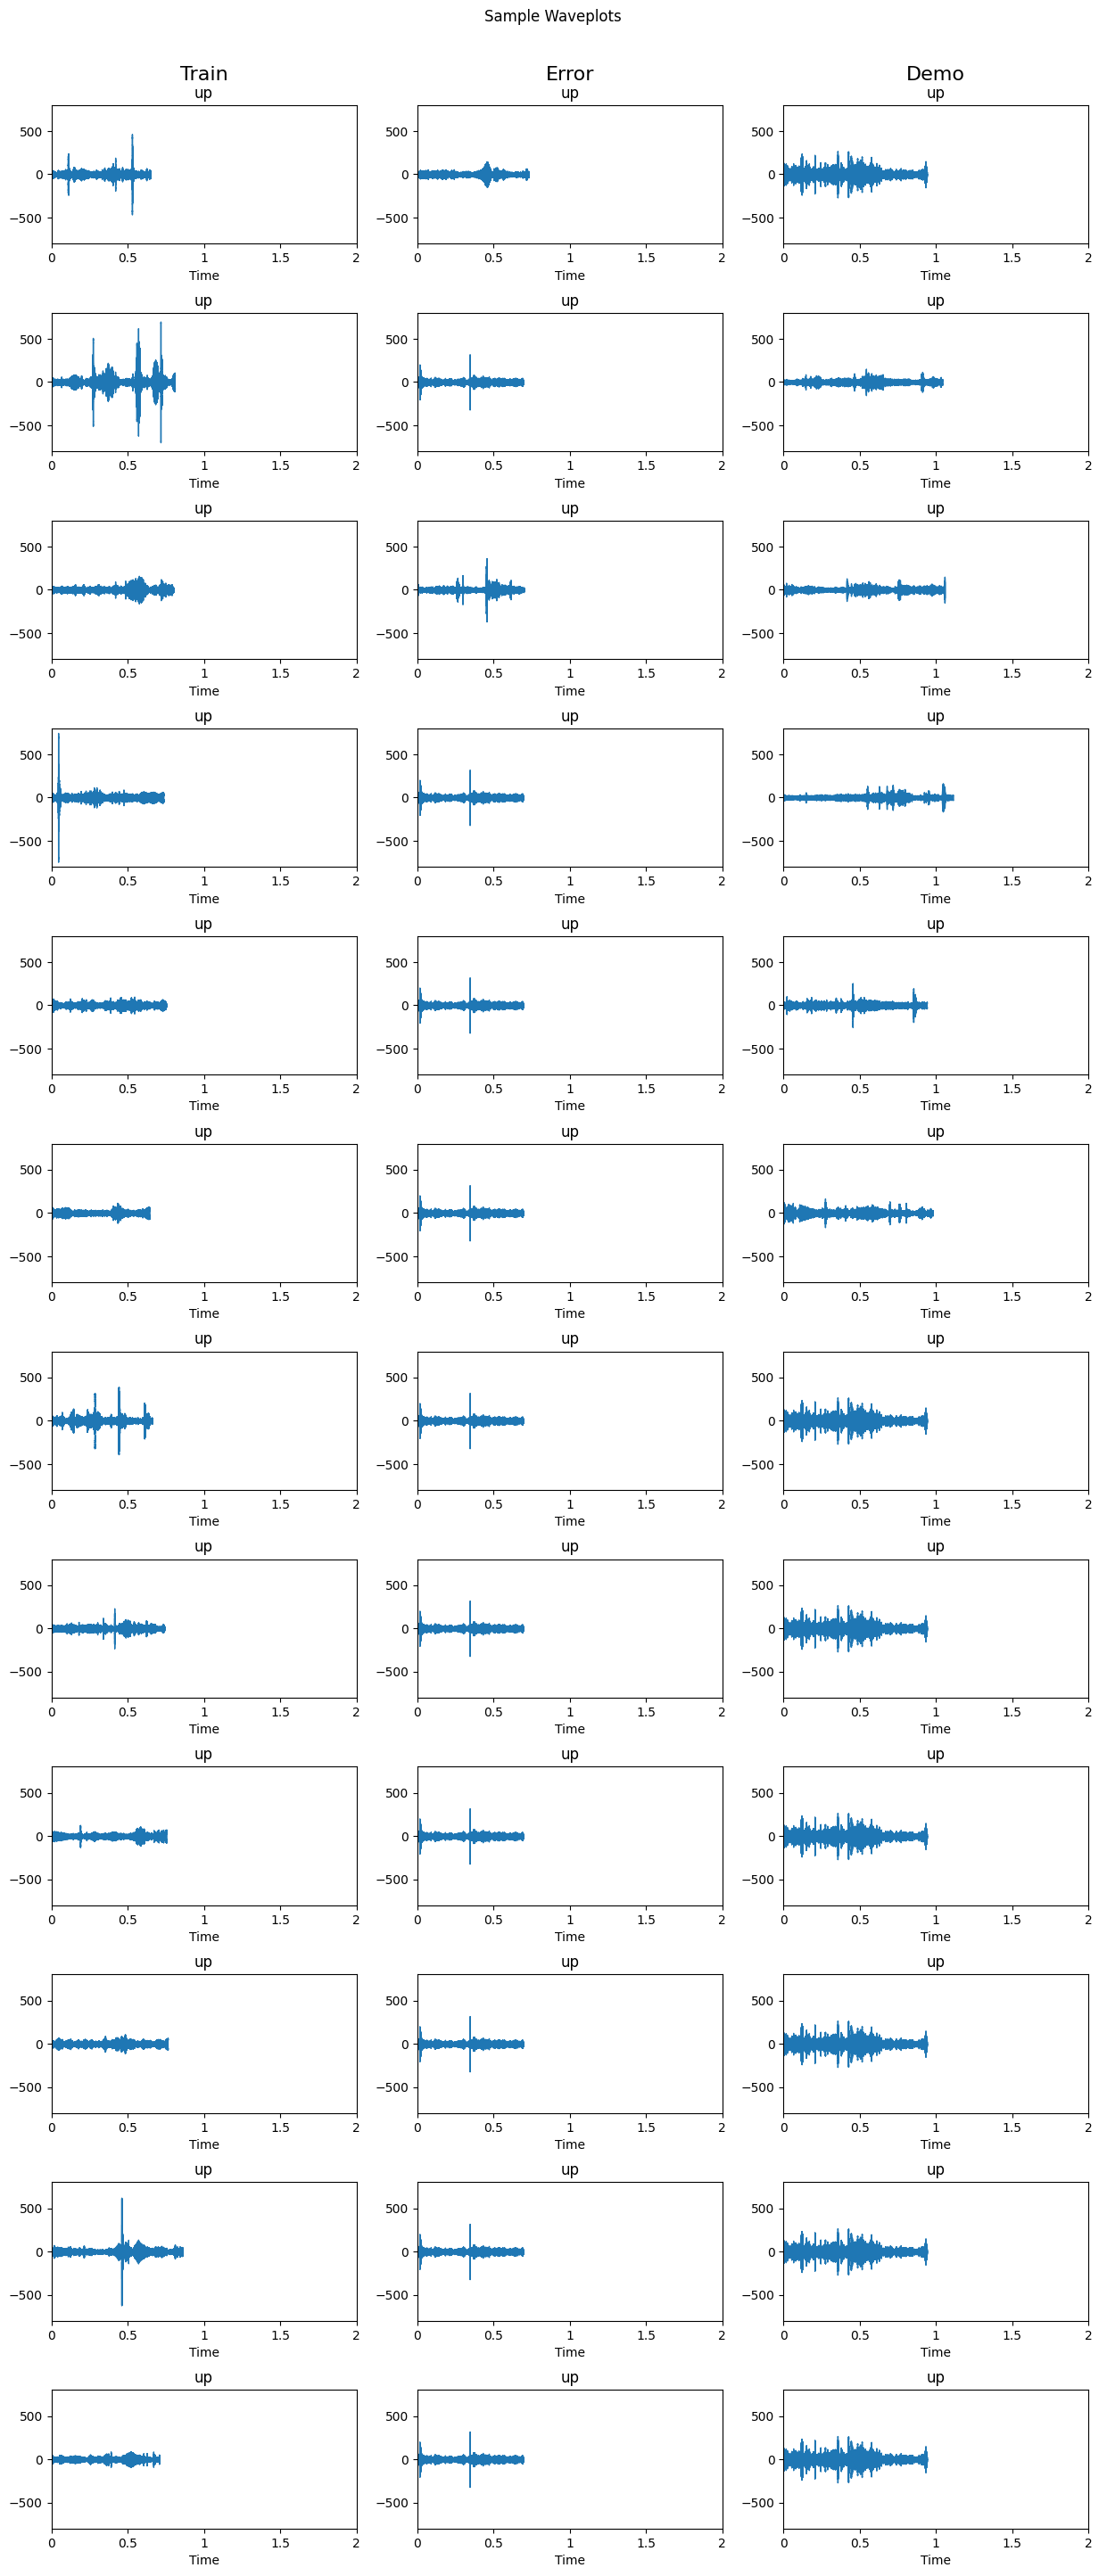

In [22]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(15, num_samples * 3), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    for n, idx in enumerate(split["sample_idxs"]):
        ax = fig.add_subplot(num_samples, len(all_splits), n * len(all_splits) + i + 1)
        plot_wave(throat_sr, split[label]["raw_throat_1"][idx], ax, split["sample_targets"][idx])
        
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.suptitle("Sample Waveplots", y=0.91)
plt.show()

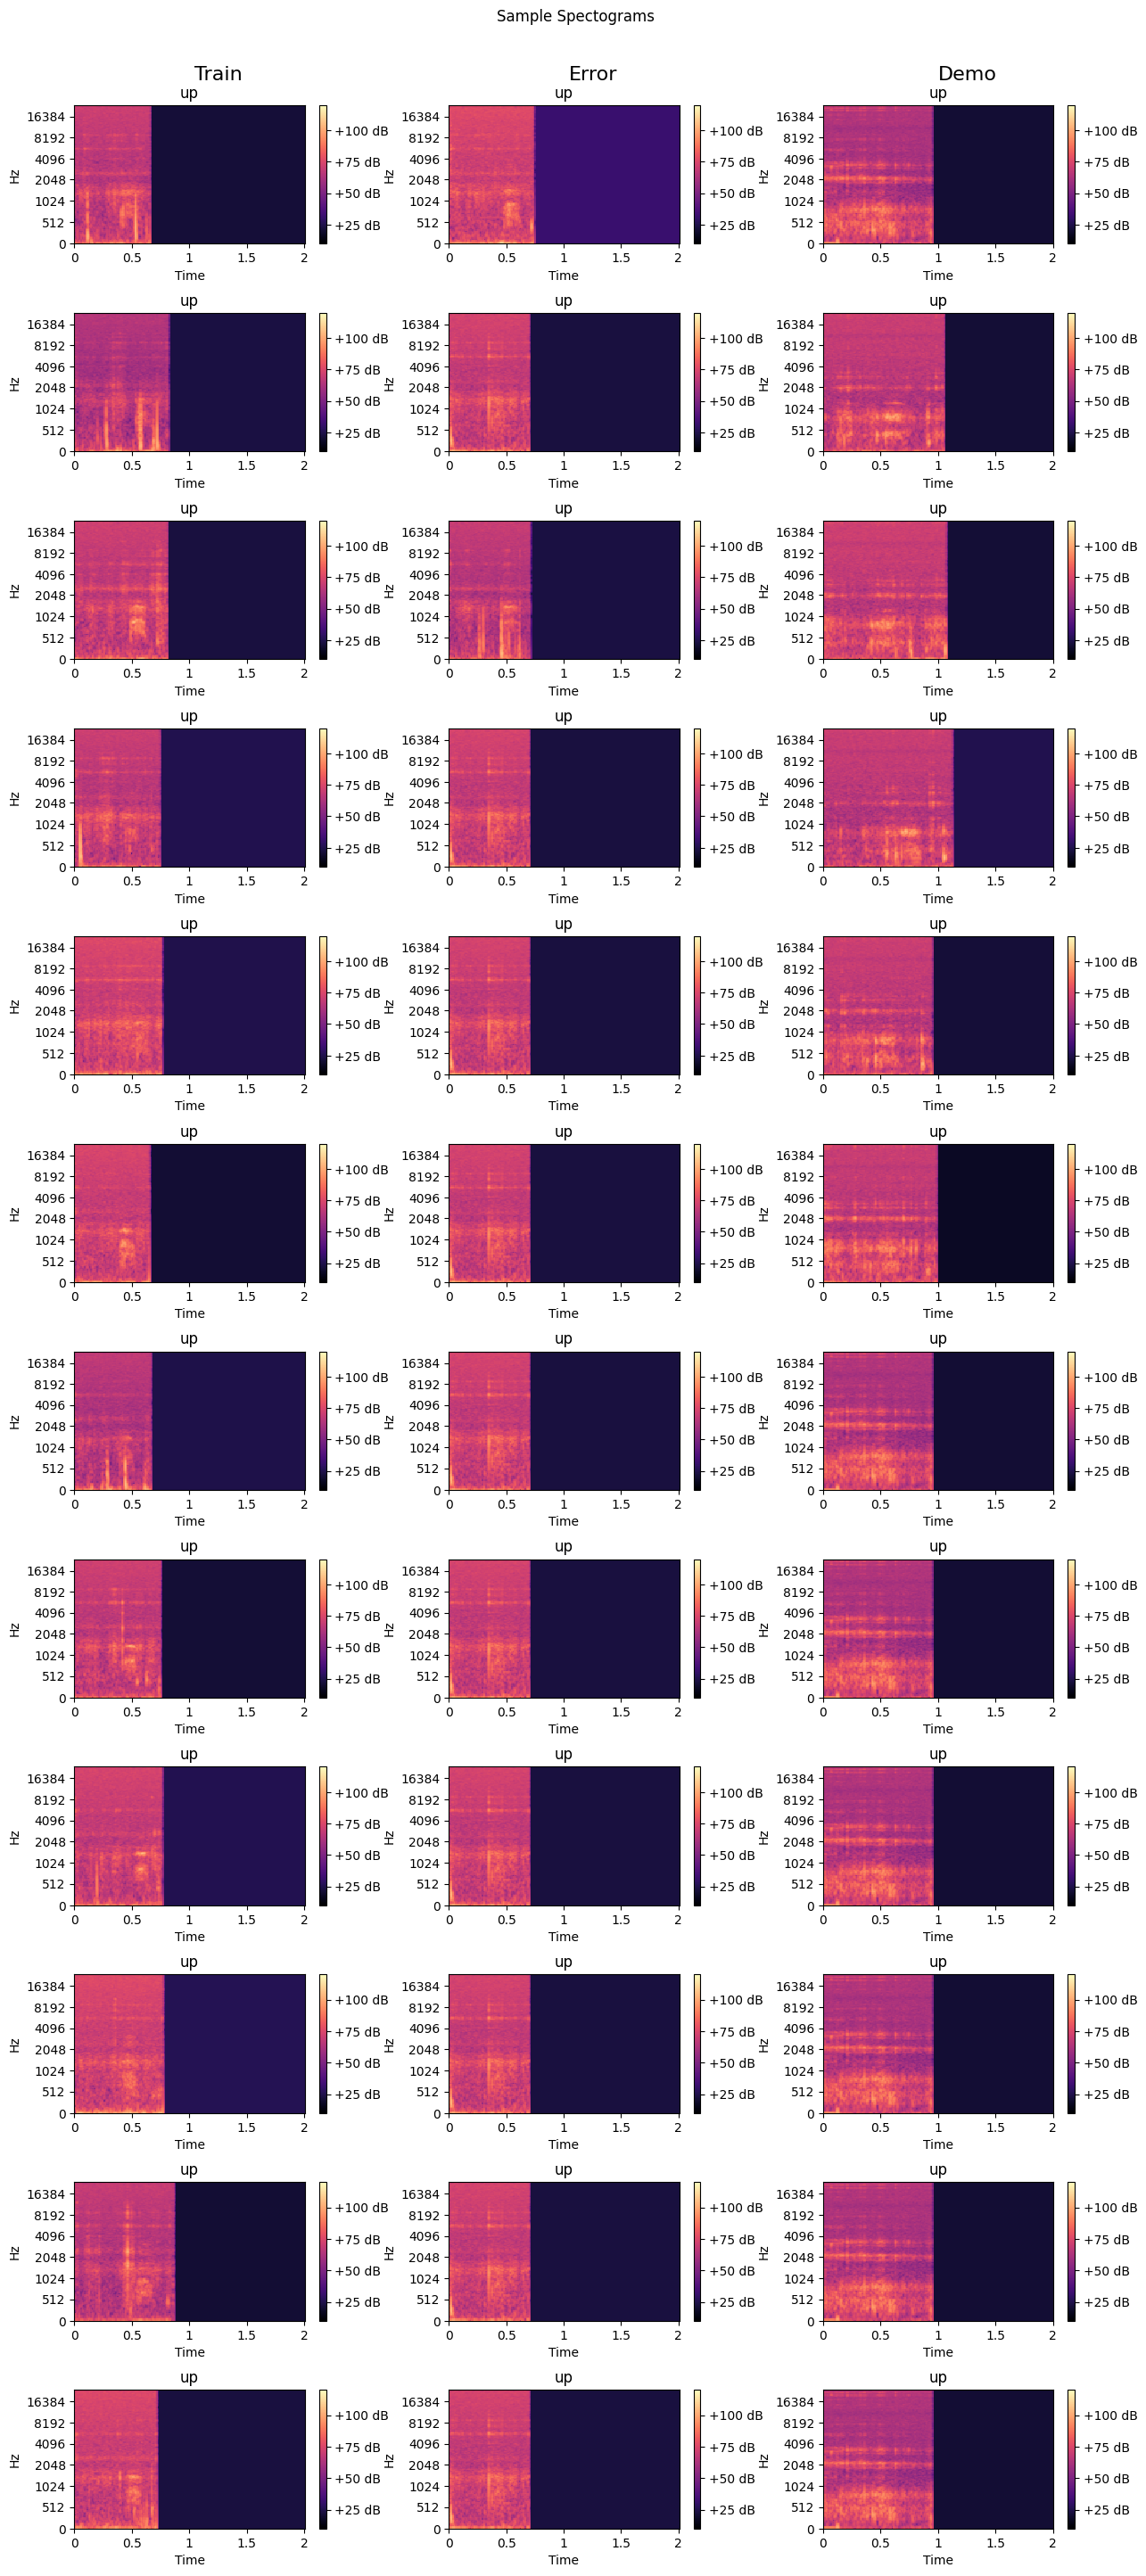

In [23]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(15, num_samples * 3), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    for n, idx in enumerate(split["sample_idxs"]):
        ax = fig.add_subplot(num_samples, len(all_splits), n * len(all_splits) + i + 1)
        img = plot_spec(throat_sr, split[label]["proc_throat_1"][idx], ax, split["sample_targets"][idx])
        if img:
            fig.colorbar(img, ax=ax, format="%+2.f dB")
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Sample Spectograms", y=0.91)
plt.show()

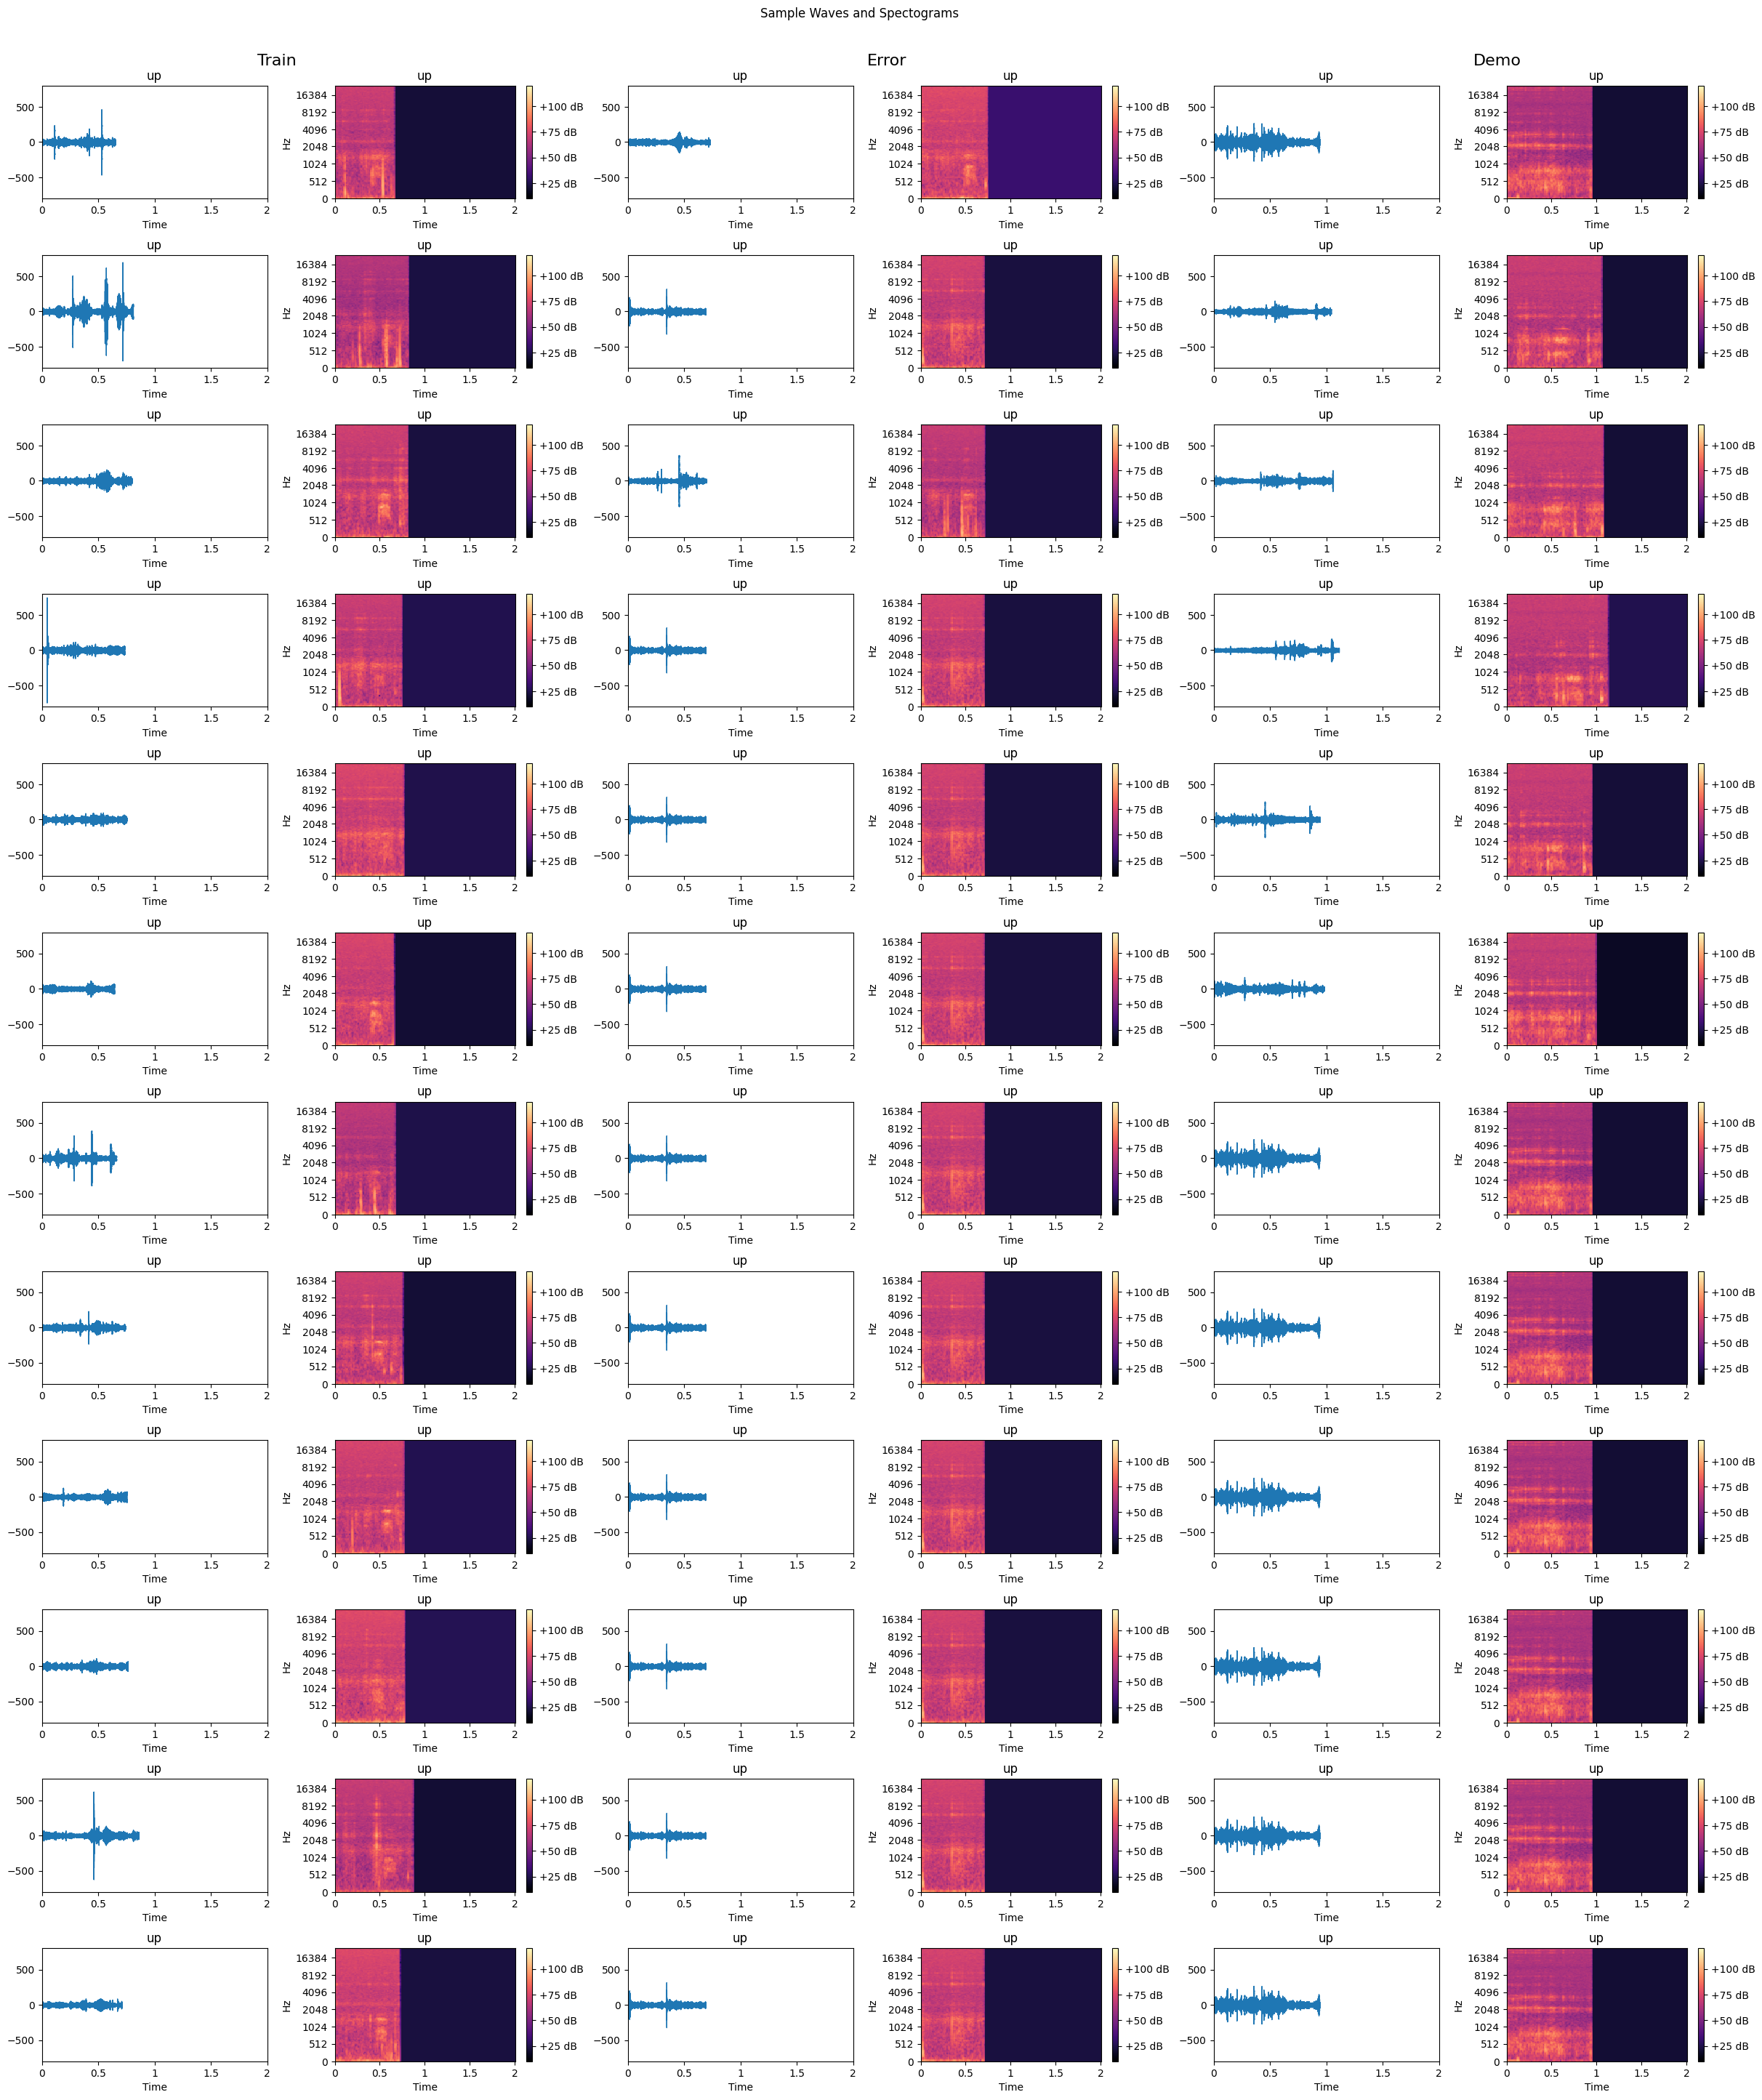

In [24]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(30, num_samples * 3), sharey=True)
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    for n, idx in enumerate(split["sample_idxs"]):
        ax_wave = fig.add_subplot(num_samples, len(all_splits) * 2, n * len(all_splits) * 2 + i * 2 + 1)
        ax_spec = fig.add_subplot(num_samples, len(all_splits) * 2, n * len(all_splits) * 2 + i * 2 + 2)
        plot_wave(throat_sr, split[label]["raw_throat_1"][idx], ax_wave, split["sample_targets"][idx])
        img = plot_spec(throat_sr, split[label]["proc_throat_1"][idx], ax_spec, split["sample_targets"][idx])
        if img:
            fig.colorbar(img, ax=ax_spec, format="%+2.f dB")
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Sample Waves and Spectograms", y=0.91)
plt.show()